In [1]:
%cd /Users/rodrigo/Post-Grad/CC400/Repo

/Users/rodrigo/Post-Grad/CC400/Repo


In [2]:
from utils import import_data, compute_KNN_graph, create_graph, create_batch,reconstruct_symmetric_matrix
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch_geometric
from torch_geometric.data import Data
from torch_geometric.utils import dense_to_sparse
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score
from sklearn.model_selection import cross_validate
from tqdm import tqdm
from torch_geometric.loader import DataLoader
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import StratifiedKFold


%matplotlib inline
sns.set(rc={'image.cmap': 'coolwarm'})

#from numba import jit,prange

import time
import os

SMALL_SIZE = 8
MEDIUM_SIZE = 14
BIGGER_SIZE = 20

plt.rc('font', size=MEDIUM_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=BIGGER_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=BIGGER_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=MEDIUM_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

scoring = {'acc': 'accuracy',
           'prec_macro': 'precision_macro',
           'rec_macro': 'recall_macro',
          'f1' : 'f1_macro',
          'roc_auc' : 'roc_auc'}


In [3]:
print(torch.__version__)

1.13.1


In [4]:
print(torch_geometric.__version__)

2.1.0


In [5]:
df, phenotypic = import_data(fisher=True)
df = df.join(pd.DataFrame(phenotypic.Age), how='left')
df = df.join(pd.DataFrame(phenotypic['ADHD Measure']), how='left')
df = df.join(pd.DataFrame(phenotypic['Gender']), how='left')

df = ((df.reset_index()).drop(columns=['Institution', 'Subject'])).dropna(subset=[str(x) for x in range(0,17955)])
df = df.dropna(axis=0, subset=['Gender'])

from sklearn.utils import shuffle
df = shuffle(df, random_state=42)

# Real test set
TEST =  df.iloc[-30:]

df = df.iloc[:-30]

# Labels
y = (df.Gender).apply(lambda x: int(x))

# Remove from Fisher-space
X = np.tanh(df.iloc[:,:-3])
X_TEST =  np.tanh(TEST.iloc[:,:-3])
y_TEST =  (TEST.Gender).apply(lambda x: int(x))


In [6]:
group_fc = pd.read_csv(r'/Users/rodrigo/Post-Grad/CC400/Group_FC.csv').iloc[:,1]

In [7]:
print(' 0 = {:.2f}% \n'.format(y.value_counts()[0]/len(y)), '1 = {:.2f}%'.format(y.value_counts()[1]/len(y)))

 0 = 0.37% 
 1 = 0.63%


In [8]:
from sklearn.model_selection import train_test_split

# Split train and validation set
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.15, shuffle=True, random_state=42)

In [9]:
from sklearn.dummy import DummyClassifier
dummy = DummyClassifier(strategy="most_frequent")
dummy.fit(X_test, y_test)

# Make predictions on the testing data
pred_y = dummy.predict(X_test)

scores = cross_validate(dummy, X, y, cv=5, scoring=scoring)

print("Accuracy in test:%0.2f(%0.2f)" % (scores['test_acc'].mean(), scores['test_acc'].std()))
print("F1_scores {:.2f}({:.2f})".format(scores['test_f1'].mean(), scores['test_f1'].std()))
print("Precision_scores {:.2f}({:.2f})".format(scores['test_prec_macro'].mean(), scores['test_prec_macro'].std()))
print("Recall_scores {:.2f}({:.2f})".format(scores['test_rec_macro'].mean(), scores['test_rec_macro'].std()))
print("ROC AUC {:.2f}({:.2f})".format(scores['test_roc_auc'].mean(), scores['test_roc_auc'].std()))
print('Dummy accuracy score in TEST set: {0:0.4f}'. format(accuracy_score(y_TEST, dummy.predict(X_TEST))))

Accuracy in test:0.63(0.00)
F1_scores 0.39(0.00)
Precision_scores 0.31(0.00)
Recall_scores 0.50(0.00)
ROC AUC 0.50(0.00)
Dummy accuracy score in TEST set: 0.6000


/opt/homebrew/Caskroom/miniforge/base/envs/GCN_study/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/homebrew/Caskroom/miniforge/base/envs/GCN_study/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/homebrew/Caskroom/miniforge/base/envs/GCN_study/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_

In [10]:
A = reconstruct_symmetric_matrix(190,group_fc.values)


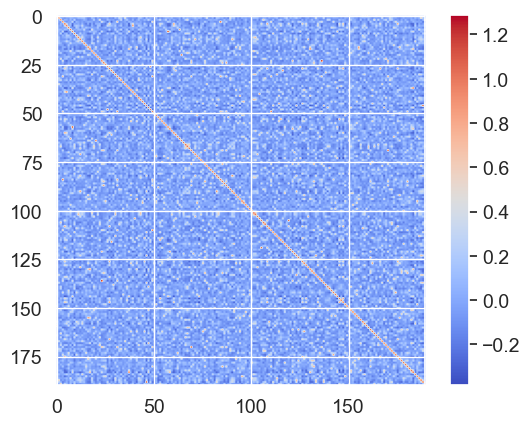

In [11]:
plt.imshow(A)
plt.colorbar()
plt.show()

## K-NN for selecting edges

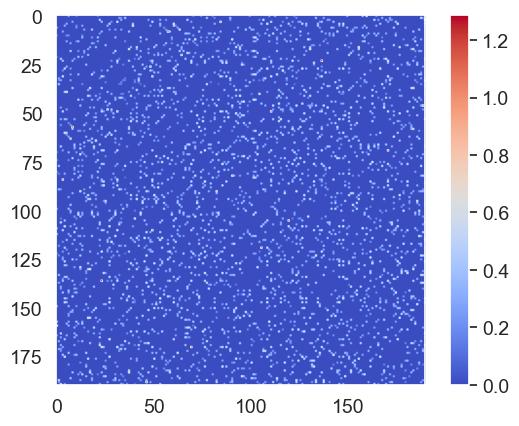

In [85]:
plt.imshow(np.array(compute_KNN_graph(A, 15)))
plt.colorbar()
plt.grid(False)
plt.show()

## Creating the graphs

In [86]:
train_data, val_data = create_graph(X_train, X_test, y_train, y_test, method={'knn_group' : compute_KNN_graph(A, 10)})# method={'knn' : 10}) #,method={'threshold': 0.2})

train_data, TEST_data = create_graph(X_train, X_TEST, y_train, y_TEST, method={'knn_group' : compute_KNN_graph(A, 10)})# method={'knn' : 10}) #,method={'threshold': 0.2})

In [87]:
print(train_data[-1])

Data(x=[190, 190], edge_index=[2, 2224], edge_attr=[2224, 1], y=0)


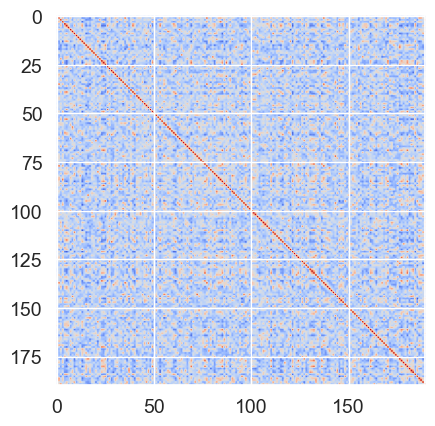

In [88]:
plt.imshow(train_data[-1].x)

In [89]:
train_loader, val_loader = create_batch(train_data, val_data, batch_size=20)

TRAIN_loader, TEST_loader = create_batch(train_data, TEST_data, batch_size=20)

In [90]:
print('Validation balance \n 0 = {:.2f}% \n'.format(y_test.value_counts()[0]/len(y_test)), '1 = {:.2f}%'.format(y_test.value_counts()[1]/len(y_test)))
print('----------------------')
print('TEST balance \n 0 = {:.2f}% \n'.format(y_TEST.value_counts()[0]/len(y_TEST)), '1 = {:.2f}%'.format(y_TEST.value_counts()[1]/len(y_TEST)))

Validation balance 
 0 = 0.32% 
 1 = 0.68%
----------------------
TEST balance 
 0 = 0.40% 
 1 = 0.60%


In [91]:
import torch
import torch.nn.functional as func
from torch_geometric.nn import ChebConv, GCNConv, global_mean_pool, GATv2Conv, global_max_pool


class GCN(torch.nn.Module):
    """GCN model(network architecture can be modified)"""

    def __init__(self,
                 num_features,
                 num_classes,
                 k_order,
                 dropout=.5):
        super(GCN, self).__init__()

        self.p = dropout
        
        #self.conv1 = GCNConv(int(num_features), 148)
        #self.conv2 = GCNConv(148,100)
        #self.conv3 = GCNConv(64,32)
        
        #self.gat1 = GATv2Conv(int(num_features), 8, heads=4, edge_dim=1)
        #self.gat2 = GATv2Conv(148*4, 112, heads=1)
        #self.gat3 = GATv2Conv(128*2, 148, heads=1)
        
        self.conv1 = ChebConv(int(num_features), 8, K=k_order)
        #self.conv2 = ChebConv(16, 8, K=k_order)
        #self.conv3 = ChebConv(72, 36, K=k_order)

        self.lin1 = torch.nn.Linear(8*4, 2)
        #self.lin2 = torch.nn.Linear(4, int(num_classes))
        
        #torch.nn.init.xavier_normal_(self.gat1)
        #torch.nn.init.xavier_normal_(self.gat2)
        torch.nn.init.xavier_normal_(self.lin1.weight)


        self.bn1 = torch.nn.BatchNorm1d(148)
        self.bn2 = torch.nn.BatchNorm1d(72)
        self.bn3 = torch.nn.BatchNorm1d(36)
        
        self.pool = global_mean_pool

    def forward(self, data):
        x, edge_index, edge_attr = data.x, data.edge_index, data.edge_attr
        batch = data.batch

        #x = func.relu(self.conv1(x, edge_index, edge_attr))  #WHY NAN WITH EDGE_ATTR (non-negative)
        x = self.gat1(x=x, edge_index = edge_index, edge_attr=edge_attr) #func.elu(self.gat1(x=x, edge_index = edge_index, edge_attr=edge_attr))
        #x = func.dropout(x, p=self.p, training=self.training)
        #x = self.bn1(x)
        #x = func.relu(self.conv2(x, edge_index, edge_attr))  #WHY NAN WITH EDGE_ATTR (non-negative)
        #x = func.elu(self.gat2(x, edge_index))
        #x = func.dropout(x, p=self.p, training=self.training)
        #x = self.bn2(x)
        #x = func.relu(self.conv3(x, edge_index,edge_attr))  #, edge_attr, batch))  #WHY NAN WITH EDGE_ATTR (non-negative)
        #x = func.elu(self.gat3(x, edge_index))
        #x = func.dropout(x, p=self.p, training=self.training)
        #x = self.bn3(x)
            
        #x = func.elu(self.gat3(x, edge_index))
        #x = func.dropout(x, p=self.p, training=self.training)
        
        x = self.pool(x, batch)
        #x = func.log_softmax(x, dim=1)
        x = self.lin1(x)
        #x = func.dropout(x, p=self.p, training=self.training)
        #x = self.lin2(x)
        #x = func.dropout(x, p=self.p, training=self.training)
        #print(x.shape)
        return x

In [92]:
def init_weights(m):
    if isinstance(m, GATv2Conv):
        m.reset_parameters()
        if m.bias is not None: 
            nn.init.zeros_(m.bias)
    if isinstance(m, nn.Linear):
        m.reset_parameters()
        #nn.init.normal_(m.weight, mean=0.0, std=np.sqrt(1 / m.in_features))
        if m.bias is not None: 
            nn.init.zeros_(m.bias)


In [93]:
import torch
import torch.nn as nn

# Define the cosine proximity loss function
class CosineProximityLoss(nn.Module):
    def __init__(self):
        super(CosineProximityLoss, self).__init__()
        self.cosine_similarity = nn.CosineSimilarity(dim=1)
    
    def forward(self, y_true, y_pred):
        # y_true and y_pred are tensors of shape (batch_size, num_classes)
        # The loss is the negative of the cosine similarity
        loss = - self.cosine_similarity(y_true, y_pred)
        return loss.mean()
    
#loss = CosineProximityLoss()
#loss = loss(func.softmax(output).max(dim=1).values.reshape(len(y.y),1), y.y.float().reshape(len(y.y),1))
    

# Testing in one fold

In [94]:
def TRAIN_LOSS(loader):
    model.eval()
    l1_weight = 1e-4
    
    pred = []
    label = []
    
    loss_all = 0
    for data in loader:
        data = data.to(device)
        output = model(data)
        l1_penalty = l1_weight * sum([p.abs().sum() for p in model.parameters()])
        loss = func.cross_entropy(output, data.y)
        loss_with_penalty = loss + l1_penalty
        loss_all += data.num_graphs * loss_with_penalty.item()
        pred.append(func.softmax(output, dim=1).max(dim=1)[1])
        label.append(data.y)

    y_pred = torch.cat(pred, dim=0).cpu().detach().numpy()
    y_true = torch.cat(label, dim=0).cpu().detach().numpy()
    tn, fp, fn, tp = confusion_matrix(y_pred, y_true).ravel()
    epoch_acc = (tn + tp) / (tn + tp + fn + fp)
    
    # AUC & ROC
    # fpr, tpr, _ = roc_curve(y_true, y_pred)
    # roc_auc = auc(fpr, tpr)
    
    return epoch_acc, loss_all / len(train_data)

def GCN_train(loader, loop):
    model.train()
    l1_weight = 1e-4
    loss_all = 0
    pred = []
    label = []
    
        
    for (x, y) in enumerate(loop):
        y = y.to(device)
        optimizer.zero_grad()
        output = model(y)
        #print(output)
        # Adding L1 regularization
        l1_penalty = l1_weight * sum([p.abs().sum() for p in model.parameters()])
        loss = func.cross_entropy(output, y.y)
        loss_with_penalty = loss + l1_penalty
        loss_with_penalty.backward()
        optimizer.step()
        loss_all += y.num_graphs * loss_with_penalty.item()
        pred.append(func.softmax(output, dim=1).max(dim=1)[1])
        label.append(y.y)

        loop.set_description(f"Epoch [{epoch}/{NUM_EPOCHS}]")
        loop.set_postfix(loss=loss_all/len(train_data))
        #optimizer.step()
    y_pred = torch.cat(pred, dim=0).cpu().detach().numpy()
    y_true = torch.cat(label, dim=0).cpu().detach().numpy()
    tn, fp, fn, tp = confusion_matrix(y_pred, y_true).ravel()
    epoch_acc = (tn + tp) / (tn + tp + fn + fp)
        
    return epoch_acc, loss_all / len(train_data)


def GCN_test(loader):
    
    model.eval()
    l1_weight = 1e-4
    
    pred = []
    label = []
    
    loss_all = 0
    for data in loader:
        data = data.to(device)
        output = model(data)
        l1_penalty = l1_weight * sum([p.abs().sum() for p in model.parameters()])
        loss = func.cross_entropy(output, data.y)
        loss_with_penalty = loss + l1_penalty
        loss_all += data.num_graphs * loss_with_penalty.item()
        pred.append(func.softmax(output, dim=1).max(dim=1)[1])
        label.append(data.y)

    y_pred = torch.cat(pred, dim=0).cpu().detach().numpy()
    y_true = torch.cat(label, dim=0).cpu().detach().numpy()
    tn, fp, fn, tp = confusion_matrix(y_pred, y_true).ravel()
    epoch_rec = tp / (tp + fn)
    epoch_prec = tp / (tp + fp)
    epoch_f1 = 2*(epoch_rec*epoch_prec)/(epoch_rec + epoch_prec)
    epoch_acc = (tn + tp) / (tn + tp + fn + fp)
    
    # AUC & ROC
    fpr, tpr, _ = roc_curve(y_true, y_pred)
    roc_auc = auc(fpr, tpr)
    
    return epoch_rec, epoch_prec, epoch_acc, loss_all / len(val_data), roc_auc,epoch_f1


In [95]:
metrics = {"loss_train" : [], "loss_test" : [], "acc_test" : [], "acc_train" : []}

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = GCN(190, 2, 3).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-2, weight_decay=1e-2)#,momentum=0.35)
scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[40], gamma=1, verbose=True)

for layer in model.children():
    if hasattr(layer, 'reset_parameters'):
        layer.reset_parameters()
   
model.apply(init_weights)

min_v_loss = np.inf  

NUM_EPOCHS = 150

for epoch in range(1,NUM_EPOCHS + 1):
    loop = tqdm(train_loader)
    train_acc, train_loss = GCN_train(train_loader,loop)
    test_rec, test_prec, test_acc, test_loss, roc_auc, test_f1 = GCN_test(val_loader)
    TRAIN_acc, TRAIN_loss = TRAIN_LOSS(train_loader)
    
    scheduler.step()
    
    metrics['loss_train'].append(TRAIN_loss)
    metrics['loss_test'].append(test_loss)
    metrics['acc_test'].append(test_acc)
    metrics['acc_train'].append(TRAIN_acc)
    
    print('Val Accuracy {} , Val Loss {}'.format(test_acc, test_loss))
    print('Train Accuracy {} , Train Loss {}'.format(TRAIN_acc, TRAIN_loss))

#     y_pred = {'x1' : [], 'x2' : [], 'label' : []}
#     for y in val_loader:
#         y_pred['x1'].append(model(y).detach().numpy()[0][0])
#         y_pred['x2'].append(model(y).detach().numpy()[0][1])
#         y_pred['label'].append(y.y.detach().numpy()[0])
        
#     sns.scatterplot(data=pd.DataFrame.from_dict(y_pred) , x='x1', y='x2', hue='label')
#     plt.show()
    

Adjusting learning rate of group 0 to 1.0000e-02.


Epoch [1/150]: 100%|████████████████| 31/31 [00:01<00:00, 16.80it/s, loss=0.732]


Adjusting learning rate of group 0 to 1.0000e-02.
Val Accuracy 0.6788990825688074 , Val Loss 0.6724016278161915
Train Accuracy 0.6207455429497569 , Train Loss 0.6947863576284684


Epoch [2/150]: 100%|█████████████████| 31/31 [00:01<00:00, 15.62it/s, loss=0.69]


Adjusting learning rate of group 0 to 1.0000e-02.
Val Accuracy 0.6788990825688074 , Val Loss 0.652354259009755
Train Accuracy 0.6207455429497569 , Train Loss 0.6785312380937548


Epoch [3/150]: 100%|████████████████| 31/31 [00:01<00:00, 18.47it/s, loss=0.679]


Adjusting learning rate of group 0 to 1.0000e-02.
Val Accuracy 0.6788990825688074 , Val Loss 0.64507034557675
Train Accuracy 0.6207455429497569 , Train Loss 0.6724459198537484


Epoch [4/150]: 100%|████████████████| 31/31 [00:01<00:00, 19.36it/s, loss=0.674]


Adjusting learning rate of group 0 to 1.0000e-02.
Val Accuracy 0.6788990825688074 , Val Loss 0.6416134167154994
Train Accuracy 0.6207455429497569 , Train Loss 0.669169840395354


Epoch [5/150]: 100%|████████████████| 31/31 [00:01<00:00, 17.33it/s, loss=0.671]


Adjusting learning rate of group 0 to 1.0000e-02.
Val Accuracy 0.6788990825688074 , Val Loss 0.6394795843767463
Train Accuracy 0.6207455429497569 , Train Loss 0.6672320032622091


Epoch [6/150]: 100%|█████████████████| 31/31 [00:01<00:00, 18.68it/s, loss=0.67]


Adjusting learning rate of group 0 to 1.0000e-02.
Val Accuracy 0.6788990825688074 , Val Loss 0.6382504671538641
Train Accuracy 0.6207455429497569 , Train Loss 0.6662698980281959


Epoch [7/150]: 100%|████████████████| 31/31 [00:01<00:00, 19.31it/s, loss=0.669]


Adjusting learning rate of group 0 to 1.0000e-02.
Val Accuracy 0.6788990825688074 , Val Loss 0.6373063055200314
Train Accuracy 0.6207455429497569 , Train Loss 0.665834356938614


Epoch [8/150]: 100%|████████████████| 31/31 [00:02<00:00, 13.76it/s, loss=0.669]


Adjusting learning rate of group 0 to 1.0000e-02.
Val Accuracy 0.6788990825688074 , Val Loss 0.6366831857130069
Train Accuracy 0.6207455429497569 , Train Loss 0.6656513962792037


Epoch [9/150]: 100%|████████████████| 31/31 [00:01<00:00, 16.12it/s, loss=0.669]


Adjusting learning rate of group 0 to 1.0000e-02.
Val Accuracy 0.6788990825688074 , Val Loss 0.6362948636396215
Train Accuracy 0.6207455429497569 , Train Loss 0.6655622399027189


Epoch [10/150]: 100%|███████████████| 31/31 [00:02<00:00, 12.86it/s, loss=0.668]


Adjusting learning rate of group 0 to 1.0000e-02.
Val Accuracy 0.6788990825688074 , Val Loss 0.6367345589016555
Train Accuracy 0.6207455429497569 , Train Loss 0.6655509916271537


Epoch [11/150]: 100%|███████████████| 31/31 [00:01<00:00, 18.63it/s, loss=0.668]


Adjusting learning rate of group 0 to 1.0000e-02.
Val Accuracy 0.6788990825688074 , Val Loss 0.6366875179863851
Train Accuracy 0.6207455429497569 , Train Loss 0.6655206820373597


Epoch [12/150]: 100%|███████████████| 31/31 [00:01<00:00, 16.63it/s, loss=0.667]


Adjusting learning rate of group 0 to 1.0000e-02.
Val Accuracy 0.6788990825688074 , Val Loss 0.6362815652418574
Train Accuracy 0.6207455429497569 , Train Loss 0.6654026675456154


Epoch [13/150]: 100%|███████████████| 31/31 [00:02<00:00, 15.21it/s, loss=0.667]


Adjusting learning rate of group 0 to 1.0000e-02.
Val Accuracy 0.6788990825688074 , Val Loss 0.6363159587623877
Train Accuracy 0.6207455429497569 , Train Loss 0.665366548386733


Epoch [14/150]: 100%|███████████████| 31/31 [00:02<00:00, 12.60it/s, loss=0.668]


Adjusting learning rate of group 0 to 1.0000e-02.
Val Accuracy 0.6788990825688074 , Val Loss 0.6358892480167774
Train Accuracy 0.6207455429497569 , Train Loss 0.6652589609402698


Epoch [15/150]: 100%|███████████████| 31/31 [00:01<00:00, 15.95it/s, loss=0.667]


Adjusting learning rate of group 0 to 1.0000e-02.
Val Accuracy 0.6788990825688074 , Val Loss 0.6354799945966914
Train Accuracy 0.6207455429497569 , Train Loss 0.6651914240475412


Epoch [16/150]: 100%|███████████████| 31/31 [00:01<00:00, 16.58it/s, loss=0.666]


Adjusting learning rate of group 0 to 1.0000e-02.
Val Accuracy 0.6788990825688074 , Val Loss 0.6361915056311757
Train Accuracy 0.6207455429497569 , Train Loss 0.665101683796708


Epoch [17/150]: 100%|███████████████| 31/31 [00:02<00:00, 14.62it/s, loss=0.666]


Adjusting learning rate of group 0 to 1.0000e-02.
Val Accuracy 0.6788990825688074 , Val Loss 0.6365063288889894
Train Accuracy 0.6207455429497569 , Train Loss 0.6650274370825657


Epoch [18/150]: 100%|███████████████| 31/31 [00:01<00:00, 16.05it/s, loss=0.666]


Adjusting learning rate of group 0 to 1.0000e-02.
Val Accuracy 0.6788990825688074 , Val Loss 0.6363868494646265
Train Accuracy 0.6207455429497569 , Train Loss 0.665059545341535


Epoch [19/150]: 100%|███████████████| 31/31 [00:01<00:00, 18.76it/s, loss=0.667]


Adjusting learning rate of group 0 to 1.0000e-02.
Val Accuracy 0.6788990825688074 , Val Loss 0.6378609937265378
Train Accuracy 0.6207455429497569 , Train Loss 0.6654317492024439


Epoch [20/150]: 100%|███████████████| 31/31 [00:01<00:00, 18.97it/s, loss=0.666]


Adjusting learning rate of group 0 to 1.0000e-02.
Val Accuracy 0.6788990825688074 , Val Loss 0.6376015101004084
Train Accuracy 0.6207455429497569 , Train Loss 0.665299723368603


Epoch [21/150]: 100%|███████████████| 31/31 [00:01<00:00, 19.55it/s, loss=0.666]


Adjusting learning rate of group 0 to 1.0000e-02.
Val Accuracy 0.6788990825688074 , Val Loss 0.636975525989445
Train Accuracy 0.6207455429497569 , Train Loss 0.6650968470295205


Epoch [22/150]: 100%|███████████████| 31/31 [00:01<00:00, 19.53it/s, loss=0.666]


Adjusting learning rate of group 0 to 1.0000e-02.
Val Accuracy 0.6788990825688074 , Val Loss 0.6366557875357637
Train Accuracy 0.6207455429497569 , Train Loss 0.6651360066049102


Epoch [23/150]: 100%|███████████████| 31/31 [00:01<00:00, 19.38it/s, loss=0.666]


Adjusting learning rate of group 0 to 1.0000e-02.
Val Accuracy 0.6788990825688074 , Val Loss 0.6366304911057884
Train Accuracy 0.6207455429497569 , Train Loss 0.6651952987358675


Epoch [24/150]: 100%|███████████████| 31/31 [00:01<00:00, 20.12it/s, loss=0.666]


Adjusting learning rate of group 0 to 1.0000e-02.
Val Accuracy 0.6788990825688074 , Val Loss 0.6365802881367709
Train Accuracy 0.6207455429497569 , Train Loss 0.6652201756086303


Epoch [25/150]: 100%|███████████████| 31/31 [00:01<00:00, 20.22it/s, loss=0.666]


Adjusting learning rate of group 0 to 1.0000e-02.
Val Accuracy 0.6788990825688074 , Val Loss 0.6364857751295108
Train Accuracy 0.6207455429497569 , Train Loss 0.6652302844404595


Epoch [26/150]: 100%|███████████████| 31/31 [00:01<00:00, 20.31it/s, loss=0.666]


Adjusting learning rate of group 0 to 1.0000e-02.
Val Accuracy 0.6788990825688074 , Val Loss 0.6363808731420324
Train Accuracy 0.6207455429497569 , Train Loss 0.6652435803336108


Epoch [27/150]: 100%|███████████████| 31/31 [00:01<00:00, 19.09it/s, loss=0.667]


Adjusting learning rate of group 0 to 1.0000e-02.
Val Accuracy 0.6788990825688074 , Val Loss 0.6362964450766188
Train Accuracy 0.6207455429497569 , Train Loss 0.6652508842693928


Epoch [28/150]: 100%|███████████████| 31/31 [00:01<00:00, 19.69it/s, loss=0.667]


Adjusting learning rate of group 0 to 1.0000e-02.
Val Accuracy 0.6788990825688074 , Val Loss 0.6362784056488527
Train Accuracy 0.6207455429497569 , Train Loss 0.6652756391313512


Epoch [29/150]: 100%|███████████████| 31/31 [00:01<00:00, 19.28it/s, loss=0.667]


Adjusting learning rate of group 0 to 1.0000e-02.
Val Accuracy 0.6788990825688074 , Val Loss 0.6362792253494263
Train Accuracy 0.6207455429497569 , Train Loss 0.6652724833697129


Epoch [30/150]: 100%|███████████████| 31/31 [00:01<00:00, 20.18it/s, loss=0.666]


Adjusting learning rate of group 0 to 1.0000e-02.
Val Accuracy 0.6788990825688074 , Val Loss 0.6363320725226621
Train Accuracy 0.6207455429497569 , Train Loss 0.6652628593931709


Epoch [31/150]: 100%|███████████████| 31/31 [00:01<00:00, 19.97it/s, loss=0.666]


Adjusting learning rate of group 0 to 1.0000e-02.
Val Accuracy 0.6788990825688074 , Val Loss 0.6364312111784559
Train Accuracy 0.6207455429497569 , Train Loss 0.6652534012856322


Epoch [32/150]: 100%|███████████████| 31/31 [00:01<00:00, 20.15it/s, loss=0.666]


Adjusting learning rate of group 0 to 1.0000e-02.
Val Accuracy 0.6788990825688074 , Val Loss 0.6365244569034751
Train Accuracy 0.6207455429497569 , Train Loss 0.6652441845913953


Epoch [33/150]: 100%|███████████████| 31/31 [00:01<00:00, 20.75it/s, loss=0.666]


Adjusting learning rate of group 0 to 1.0000e-02.
Val Accuracy 0.6788990825688074 , Val Loss 0.6365319561520848
Train Accuracy 0.6207455429497569 , Train Loss 0.6652799814794593


Epoch [34/150]: 100%|███████████████| 31/31 [00:01<00:00, 19.15it/s, loss=0.667]


Adjusting learning rate of group 0 to 1.0000e-02.
Val Accuracy 0.6788990825688074 , Val Loss 0.6383144475451303
Train Accuracy 0.6207455429497569 , Train Loss 0.6657793976885766


Epoch [35/150]: 100%|███████████████| 31/31 [00:01<00:00, 19.68it/s, loss=0.667]


Adjusting learning rate of group 0 to 1.0000e-02.
Val Accuracy 0.6788990825688074 , Val Loss 0.6385713178630269
Train Accuracy 0.6207455429497569 , Train Loss 0.6656851575285727


Epoch [36/150]: 100%|███████████████| 31/31 [00:01<00:00, 19.23it/s, loss=0.666]


Adjusting learning rate of group 0 to 1.0000e-02.
Val Accuracy 0.6788990825688074 , Val Loss 0.63729277444542
Train Accuracy 0.6207455429497569 , Train Loss 0.6653160341748156


Epoch [37/150]: 100%|███████████████| 31/31 [00:01<00:00, 19.73it/s, loss=0.666]


Adjusting learning rate of group 0 to 1.0000e-02.
Val Accuracy 0.6788990825688074 , Val Loss 0.6365147547437511
Train Accuracy 0.6207455429497569 , Train Loss 0.665293702430045


Epoch [38/150]: 100%|███████████████| 31/31 [00:01<00:00, 19.76it/s, loss=0.666]


Adjusting learning rate of group 0 to 1.0000e-02.
Val Accuracy 0.6788990825688074 , Val Loss 0.6365330287622749
Train Accuracy 0.6207455429497569 , Train Loss 0.6653132264772535


Epoch [39/150]: 100%|███████████████| 31/31 [00:01<00:00, 20.44it/s, loss=0.666]


Adjusting learning rate of group 0 to 1.0000e-02.
Val Accuracy 0.6788990825688074 , Val Loss 0.6366717990385283
Train Accuracy 0.6207455429497569 , Train Loss 0.6653130788663991


Epoch [40/150]: 100%|███████████████| 31/31 [00:01<00:00, 20.07it/s, loss=0.666]


Adjusting learning rate of group 0 to 1.0000e-02.
Val Accuracy 0.6788990825688074 , Val Loss 0.6367375432351313
Train Accuracy 0.6207455429497569 , Train Loss 0.6652780923889754


Epoch [41/150]: 100%|███████████████| 31/31 [00:01<00:00, 19.74it/s, loss=0.666]


Adjusting learning rate of group 0 to 1.0000e-02.
Val Accuracy 0.6788990825688074 , Val Loss 0.63676109472546
Train Accuracy 0.6207455429497569 , Train Loss 0.6652634565022622


Epoch [42/150]: 100%|███████████████| 31/31 [00:01<00:00, 19.56it/s, loss=0.666]


Adjusting learning rate of group 0 to 1.0000e-02.
Val Accuracy 0.6788990825688074 , Val Loss 0.6367724649949905
Train Accuracy 0.6207455429497569 , Train Loss 0.6652703063028171


Epoch [43/150]: 100%|███████████████| 31/31 [00:01<00:00, 19.98it/s, loss=0.666]


Adjusting learning rate of group 0 to 1.0000e-02.
Val Accuracy 0.6788990825688074 , Val Loss 0.6367812676167269
Train Accuracy 0.6207455429497569 , Train Loss 0.6653179421030722


Epoch [44/150]: 100%|███████████████| 31/31 [00:01<00:00, 19.34it/s, loss=0.667]


Adjusting learning rate of group 0 to 1.0000e-02.
Val Accuracy 0.6788990825688074 , Val Loss 0.6364479568026481
Train Accuracy 0.6207455429497569 , Train Loss 0.6655676969639486


Epoch [45/150]: 100%|███████████████| 31/31 [00:01<00:00, 16.97it/s, loss=0.667]


Adjusting learning rate of group 0 to 1.0000e-02.
Val Accuracy 0.6788990825688074 , Val Loss 0.6367928098647966
Train Accuracy 0.6207455429497569 , Train Loss 0.6655572868243609


Epoch [46/150]: 100%|███████████████| 31/31 [00:01<00:00, 20.32it/s, loss=0.667]


Adjusting learning rate of group 0 to 1.0000e-02.
Val Accuracy 0.6788990825688074 , Val Loss 0.6361037254880327
Train Accuracy 0.6207455429497569 , Train Loss 0.6653008489013684


Epoch [47/150]: 100%|███████████████| 31/31 [00:01<00:00, 19.90it/s, loss=0.669]


Adjusting learning rate of group 0 to 1.0000e-02.
Val Accuracy 0.6788990825688074 , Val Loss 0.6363950472906095
Train Accuracy 0.6207455429497569 , Train Loss 0.6657989318792013


Epoch [48/150]: 100%|███████████████| 31/31 [00:01<00:00, 19.86it/s, loss=0.668]


Adjusting learning rate of group 0 to 1.0000e-02.
Val Accuracy 0.6788990825688074 , Val Loss 0.6367756010742363
Train Accuracy 0.6207455429497569 , Train Loss 0.6657547907272846


Epoch [49/150]: 100%|███████████████| 31/31 [00:01<00:00, 18.98it/s, loss=0.668]


Adjusting learning rate of group 0 to 1.0000e-02.
Val Accuracy 0.6788990825688074 , Val Loss 0.636254230770496
Train Accuracy 0.6207455429497569 , Train Loss 0.665527371958357


Epoch [50/150]: 100%|███████████████| 31/31 [00:01<00:00, 19.92it/s, loss=0.668]


Adjusting learning rate of group 0 to 1.0000e-02.
Val Accuracy 0.6788990825688074 , Val Loss 0.6354960465649946
Train Accuracy 0.6207455429497569 , Train Loss 0.6654984321161452


Epoch [51/150]: 100%|███████████████| 31/31 [00:01<00:00, 19.18it/s, loss=0.668]


Adjusting learning rate of group 0 to 1.0000e-02.
Val Accuracy 0.6788990825688074 , Val Loss 0.6327048693228206
Train Accuracy 0.6207455429497569 , Train Loss 0.6661456706458204


Epoch [52/150]: 100%|████████████████| 31/31 [00:01<00:00, 19.53it/s, loss=0.67]


Adjusting learning rate of group 0 to 1.0000e-02.
Val Accuracy 0.6788990825688074 , Val Loss 0.6378693203313635
Train Accuracy 0.6207455429497569 , Train Loss 0.6662851500549811


Epoch [53/150]: 100%|███████████████| 31/31 [00:01<00:00, 19.71it/s, loss=0.669]


Adjusting learning rate of group 0 to 1.0000e-02.
Val Accuracy 0.6788990825688074 , Val Loss 0.6387764950957867
Train Accuracy 0.6207455429497569 , Train Loss 0.6662279843704434


Epoch [54/150]: 100%|███████████████| 31/31 [00:01<00:00, 20.43it/s, loss=0.668]


Adjusting learning rate of group 0 to 1.0000e-02.
Val Accuracy 0.6788990825688074 , Val Loss 0.6372735185907521
Train Accuracy 0.6207455429497569 , Train Loss 0.6657042876248228


Epoch [55/150]: 100%|███████████████| 31/31 [00:01<00:00, 20.46it/s, loss=0.667]


Adjusting learning rate of group 0 to 1.0000e-02.
Val Accuracy 0.6788990825688074 , Val Loss 0.6363710233377754
Train Accuracy 0.6207455429497569 , Train Loss 0.6655256689271046


Epoch [56/150]: 100%|███████████████| 31/31 [00:01<00:00, 19.88it/s, loss=0.667]


Adjusting learning rate of group 0 to 1.0000e-02.
Val Accuracy 0.6788990825688074 , Val Loss 0.6362199042368373
Train Accuracy 0.6207455429497569 , Train Loss 0.6654418936811352


Epoch [57/150]: 100%|███████████████| 31/31 [00:01<00:00, 18.38it/s, loss=0.667]


Adjusting learning rate of group 0 to 1.0000e-02.
Val Accuracy 0.6788990825688074 , Val Loss 0.6364192336524298
Train Accuracy 0.6207455429497569 , Train Loss 0.6653700075814172


Epoch [58/150]: 100%|███████████████| 31/31 [00:01<00:00, 19.60it/s, loss=0.666]


Adjusting learning rate of group 0 to 1.0000e-02.
Val Accuracy 0.6788990825688074 , Val Loss 0.6366791913815595
Train Accuracy 0.6207455429497569 , Train Loss 0.6653556646945218


Epoch [59/150]: 100%|███████████████| 31/31 [00:01<00:00, 19.79it/s, loss=0.666]


Adjusting learning rate of group 0 to 1.0000e-02.
Val Accuracy 0.6788990825688074 , Val Loss 0.6367968052899072
Train Accuracy 0.6207455429497569 , Train Loss 0.6652962510357799


Epoch [60/150]: 100%|███████████████| 31/31 [00:01<00:00, 19.40it/s, loss=0.666]


Adjusting learning rate of group 0 to 1.0000e-02.
Val Accuracy 0.6788990825688074 , Val Loss 0.635283619985668
Train Accuracy 0.6207455429497569 , Train Loss 0.6654064114321766


Epoch [61/150]: 100%|███████████████| 31/31 [00:01<00:00, 19.66it/s, loss=0.667]


Adjusting learning rate of group 0 to 1.0000e-02.
Val Accuracy 0.6788990825688074 , Val Loss 0.636732698033709
Train Accuracy 0.6207455429497569 , Train Loss 0.6653774168155182


Epoch [62/150]: 100%|███████████████| 31/31 [00:01<00:00, 18.93it/s, loss=0.667]


Adjusting learning rate of group 0 to 1.0000e-02.
Val Accuracy 0.6788990825688074 , Val Loss 0.6364567085690455
Train Accuracy 0.6207455429497569 , Train Loss 0.6651969390711483


Epoch [63/150]: 100%|███████████████| 31/31 [00:01<00:00, 20.10it/s, loss=0.667]


Adjusting learning rate of group 0 to 1.0000e-02.
Val Accuracy 0.6788990825688074 , Val Loss 0.6364668717078112
Train Accuracy 0.6207455429497569 , Train Loss 0.6651934556288696


Epoch [64/150]: 100%|███████████████| 31/31 [00:01<00:00, 18.98it/s, loss=0.667]


Adjusting learning rate of group 0 to 1.0000e-02.
Val Accuracy 0.6788990825688074 , Val Loss 0.6358909412808375
Train Accuracy 0.6207455429497569 , Train Loss 0.6652687088596956


Epoch [65/150]: 100%|███████████████| 31/31 [00:01<00:00, 19.80it/s, loss=0.668]


Adjusting learning rate of group 0 to 1.0000e-02.
Val Accuracy 0.6788990825688074 , Val Loss 0.6383669647054935
Train Accuracy 0.6207455429497569 , Train Loss 0.6657807973833872


Epoch [66/150]: 100%|███████████████| 31/31 [00:01<00:00, 19.54it/s, loss=0.667]


Adjusting learning rate of group 0 to 1.0000e-02.
Val Accuracy 0.6788990825688074 , Val Loss 0.6389849987051902
Train Accuracy 0.6207455429497569 , Train Loss 0.6657720833195666


Epoch [67/150]: 100%|███████████████| 31/31 [00:01<00:00, 19.52it/s, loss=0.667]


Adjusting learning rate of group 0 to 1.0000e-02.
Val Accuracy 0.6788990825688074 , Val Loss 0.6366400847194391
Train Accuracy 0.6207455429497569 , Train Loss 0.6653947595452567


Epoch [68/150]: 100%|███████████████| 31/31 [00:01<00:00, 18.77it/s, loss=0.667]


Adjusting learning rate of group 0 to 1.0000e-02.
Val Accuracy 0.6788990825688074 , Val Loss 0.6362875732806844
Train Accuracy 0.6207455429497569 , Train Loss 0.6655369485989575


Epoch [69/150]: 100%|███████████████| 31/31 [00:01<00:00, 19.59it/s, loss=0.668]


Adjusting learning rate of group 0 to 1.0000e-02.
Val Accuracy 0.6788990825688074 , Val Loss 0.6370110506311469
Train Accuracy 0.6207455429497569 , Train Loss 0.6656172375045294


Epoch [70/150]: 100%|███████████████| 31/31 [00:01<00:00, 19.54it/s, loss=0.668]


Adjusting learning rate of group 0 to 1.0000e-02.
Val Accuracy 0.6788990825688074 , Val Loss 0.6366070842524187
Train Accuracy 0.6207455429497569 , Train Loss 0.6655443315567808


Epoch [71/150]: 100%|███████████████| 31/31 [00:01<00:00, 18.60it/s, loss=0.668]


Adjusting learning rate of group 0 to 1.0000e-02.
Val Accuracy 0.6788990825688074 , Val Loss 0.6362969965562908
Train Accuracy 0.6207455429497569 , Train Loss 0.6655628449333352


Epoch [72/150]: 100%|███████████████| 31/31 [00:01<00:00, 17.48it/s, loss=0.669]


Adjusting learning rate of group 0 to 1.0000e-02.
Val Accuracy 0.6788990825688074 , Val Loss 0.6360160828730382
Train Accuracy 0.6207455429497569 , Train Loss 0.6655236380220039


Epoch [73/150]: 100%|███████████████| 31/31 [00:01<00:00, 19.16it/s, loss=0.669]


Adjusting learning rate of group 0 to 1.0000e-02.
Val Accuracy 0.6788990825688074 , Val Loss 0.6354846500475472
Train Accuracy 0.6207455429497569 , Train Loss 0.6652667487652993


Epoch [74/150]: 100%|███████████████| 31/31 [00:01<00:00, 19.09it/s, loss=0.669]


Adjusting learning rate of group 0 to 1.0000e-02.
Val Accuracy 0.6788990825688074 , Val Loss 0.6341046633523538
Train Accuracy 0.6207455429497569 , Train Loss 0.6657994017608742


Epoch [75/150]: 100%|████████████████| 31/31 [00:01<00:00, 19.17it/s, loss=0.67]


Adjusting learning rate of group 0 to 1.0000e-02.
Val Accuracy 0.6788990825688074 , Val Loss 0.6364101064861367
Train Accuracy 0.6207455429497569 , Train Loss 0.6665122711871007


Epoch [76/150]: 100%|███████████████| 31/31 [00:01<00:00, 18.54it/s, loss=0.669]


Adjusting learning rate of group 0 to 1.0000e-02.
Val Accuracy 0.6788990825688074 , Val Loss 0.6391292165178771
Train Accuracy 0.6207455429497569 , Train Loss 0.6665506495262468


Epoch [77/150]: 100%|███████████████| 31/31 [00:01<00:00, 18.72it/s, loss=0.671]


Adjusting learning rate of group 0 to 1.0000e-02.
Val Accuracy 0.6788990825688074 , Val Loss 0.6378596107894128
Train Accuracy 0.6207455429497569 , Train Loss 0.666603245553553


Epoch [78/150]: 100%|███████████████| 31/31 [00:01<00:00, 17.24it/s, loss=0.672]


Adjusting learning rate of group 0 to 1.0000e-02.
Val Accuracy 0.6788990825688074 , Val Loss 0.6400011690384751
Train Accuracy 0.6207455429497569 , Train Loss 0.6670463641613383


Epoch [79/150]: 100%|███████████████| 31/31 [00:01<00:00, 18.88it/s, loss=0.671]


Adjusting learning rate of group 0 to 1.0000e-02.
Val Accuracy 0.6788990825688074 , Val Loss 0.6395077404625918
Train Accuracy 0.6207455429497569 , Train Loss 0.6666188927871481


Epoch [80/150]: 100%|███████████████| 31/31 [00:01<00:00, 18.79it/s, loss=0.671]


Adjusting learning rate of group 0 to 1.0000e-02.
Val Accuracy 0.6788990825688074 , Val Loss 0.6348489342479531
Train Accuracy 0.6207455429497569 , Train Loss 0.6662552609822352


Epoch [81/150]: 100%|███████████████| 31/31 [00:01<00:00, 18.38it/s, loss=0.671]


Adjusting learning rate of group 0 to 1.0000e-02.
Val Accuracy 0.6788990825688074 , Val Loss 0.6347957690921399
Train Accuracy 0.6207455429497569 , Train Loss 0.6665651782791657


Epoch [82/150]: 100%|███████████████| 31/31 [00:01<00:00, 19.11it/s, loss=0.673]


Adjusting learning rate of group 0 to 1.0000e-02.
Val Accuracy 0.6788990825688074 , Val Loss 0.6326807064747592
Train Accuracy 0.6207455429497569 , Train Loss 0.6663571918802864


Epoch [83/150]: 100%|███████████████| 31/31 [00:01<00:00, 18.99it/s, loss=0.673]


Adjusting learning rate of group 0 to 1.0000e-02.
Val Accuracy 0.6788990825688074 , Val Loss 0.6363261333846171
Train Accuracy 0.6207455429497569 , Train Loss 0.666616339641027


Epoch [84/150]: 100%|███████████████| 31/31 [00:01<00:00, 18.13it/s, loss=0.671]


Adjusting learning rate of group 0 to 1.0000e-02.
Val Accuracy 0.6788990825688074 , Val Loss 0.6370298132437084
Train Accuracy 0.6207455429497569 , Train Loss 0.6664319490497657


Epoch [85/150]: 100%|████████████████| 31/31 [00:01<00:00, 18.44it/s, loss=0.67]


Adjusting learning rate of group 0 to 1.0000e-02.
Val Accuracy 0.6788990825688074 , Val Loss 0.6385497571131505
Train Accuracy 0.6207455429497569 , Train Loss 0.6661396154128558


Epoch [86/150]: 100%|███████████████| 31/31 [00:01<00:00, 18.69it/s, loss=0.669]


Adjusting learning rate of group 0 to 1.0000e-02.
Val Accuracy 0.6788990825688074 , Val Loss 0.6367242519461781
Train Accuracy 0.6207455429497569 , Train Loss 0.6655167167345167


Epoch [87/150]: 100%|███████████████| 31/31 [00:01<00:00, 18.67it/s, loss=0.668]


Adjusting learning rate of group 0 to 1.0000e-02.
Val Accuracy 0.6788990825688074 , Val Loss 0.6354268417445892
Train Accuracy 0.6207455429497569 , Train Loss 0.6654283335761467


Epoch [88/150]: 100%|███████████████| 31/31 [00:01<00:00, 18.15it/s, loss=0.667]


Adjusting learning rate of group 0 to 1.0000e-02.
Val Accuracy 0.6788990825688074 , Val Loss 0.6358791753786419
Train Accuracy 0.6207455429497569 , Train Loss 0.6653633311849746


Epoch [89/150]: 100%|███████████████| 31/31 [00:01<00:00, 16.51it/s, loss=0.666]


Adjusting learning rate of group 0 to 1.0000e-02.
Val Accuracy 0.6788990825688074 , Val Loss 0.6364856682239323
Train Accuracy 0.6207455429497569 , Train Loss 0.665238703572383


Epoch [90/150]: 100%|███████████████| 31/31 [00:01<00:00, 17.96it/s, loss=0.666]


Adjusting learning rate of group 0 to 1.0000e-02.
Val Accuracy 0.6788990825688074 , Val Loss 0.6367441533355538
Train Accuracy 0.6207455429497569 , Train Loss 0.6651548490145605


Epoch [91/150]: 100%|███████████████| 31/31 [00:01<00:00, 18.43it/s, loss=0.666]


Adjusting learning rate of group 0 to 1.0000e-02.
Val Accuracy 0.6788990825688074 , Val Loss 0.6368106844228342
Train Accuracy 0.6207455429497569 , Train Loss 0.6651099546415493


Epoch [92/150]: 100%|███████████████| 31/31 [00:01<00:00, 17.87it/s, loss=0.666]


Adjusting learning rate of group 0 to 1.0000e-02.
Val Accuracy 0.6788990825688074 , Val Loss 0.6368215477794682
Train Accuracy 0.6207455429497569 , Train Loss 0.6650713808725873


Epoch [93/150]: 100%|███████████████| 31/31 [00:01<00:00, 16.64it/s, loss=0.666]


Adjusting learning rate of group 0 to 1.0000e-02.
Val Accuracy 0.6788990825688074 , Val Loss 0.6363255187458948
Train Accuracy 0.6207455429497569 , Train Loss 0.665131649573


Epoch [94/150]: 100%|███████████████| 31/31 [00:01<00:00, 18.12it/s, loss=0.667]


Adjusting learning rate of group 0 to 1.0000e-02.
Val Accuracy 0.6788990825688074 , Val Loss 0.6384274284227178
Train Accuracy 0.6207455429497569 , Train Loss 0.6656339165650466


Epoch [95/150]: 100%|███████████████| 31/31 [00:01<00:00, 17.19it/s, loss=0.667]


Adjusting learning rate of group 0 to 1.0000e-02.
Val Accuracy 0.6788990825688074 , Val Loss 0.638544026864778
Train Accuracy 0.6207455429497569 , Train Loss 0.6655869025078933


Epoch [96/150]: 100%|███████████████| 31/31 [00:01<00:00, 17.71it/s, loss=0.666]


Adjusting learning rate of group 0 to 1.0000e-02.
Val Accuracy 0.6788990825688074 , Val Loss 0.6375338776942787
Train Accuracy 0.6207455429497569 , Train Loss 0.6652446271341469


Epoch [97/150]: 100%|███████████████| 31/31 [00:01<00:00, 17.14it/s, loss=0.666]


Adjusting learning rate of group 0 to 1.0000e-02.
Val Accuracy 0.6788990825688074 , Val Loss 0.6366678243930187
Train Accuracy 0.6207455429497569 , Train Loss 0.6651804341875753


Epoch [98/150]: 100%|███████████████| 31/31 [00:01<00:00, 17.85it/s, loss=0.667]


Adjusting learning rate of group 0 to 1.0000e-02.
Val Accuracy 0.6788990825688074 , Val Loss 0.6363200466020391
Train Accuracy 0.6207455429497569 , Train Loss 0.6651886969176838


Epoch [99/150]: 100%|███████████████| 31/31 [00:01<00:00, 17.59it/s, loss=0.667]


Adjusting learning rate of group 0 to 1.0000e-02.
Val Accuracy 0.6788990825688074 , Val Loss 0.6342518255798095
Train Accuracy 0.6207455429497569 , Train Loss 0.665375944088112


Epoch [100/150]: 100%|██████████████| 31/31 [00:01<00:00, 17.18it/s, loss=0.667]


Adjusting learning rate of group 0 to 1.0000e-02.
Val Accuracy 0.6788990825688074 , Val Loss 0.6355097364941868
Train Accuracy 0.6207455429497569 , Train Loss 0.6652718707073836


Epoch [101/150]: 100%|██████████████| 31/31 [00:01<00:00, 17.93it/s, loss=0.668]


Adjusting learning rate of group 0 to 1.0000e-02.
Val Accuracy 0.6788990825688074 , Val Loss 0.636314889433187
Train Accuracy 0.6207455429497569 , Train Loss 0.6650584155581952


Epoch [102/150]: 100%|██████████████| 31/31 [00:01<00:00, 17.91it/s, loss=0.667]


Adjusting learning rate of group 0 to 1.0000e-02.
Val Accuracy 0.6788990825688074 , Val Loss 0.6361831869554082
Train Accuracy 0.6207455429497569 , Train Loss 0.6651526533031


Epoch [103/150]: 100%|██████████████| 31/31 [00:01<00:00, 17.74it/s, loss=0.667]


Adjusting learning rate of group 0 to 1.0000e-02.
Val Accuracy 0.6788990825688074 , Val Loss 0.6364328967868735
Train Accuracy 0.6207455429497569 , Train Loss 0.6652465302322054


Epoch [104/150]: 100%|██████████████| 31/31 [00:01<00:00, 17.48it/s, loss=0.666]


Adjusting learning rate of group 0 to 1.0000e-02.
Val Accuracy 0.6788990825688074 , Val Loss 0.636719931703095
Train Accuracy 0.6207455429497569 , Train Loss 0.6652176568535197


Epoch [105/150]: 100%|██████████████| 31/31 [00:01<00:00, 16.67it/s, loss=0.666]


Adjusting learning rate of group 0 to 1.0000e-02.
Val Accuracy 0.6788990825688074 , Val Loss 0.6368320619841235
Train Accuracy 0.6207455429497569 , Train Loss 0.6651444079617047


Epoch [106/150]: 100%|██████████████| 31/31 [00:01<00:00, 17.40it/s, loss=0.666]


Adjusting learning rate of group 0 to 1.0000e-02.
Val Accuracy 0.6788990825688074 , Val Loss 0.6368913861042863
Train Accuracy 0.6207455429497569 , Train Loss 0.6651244191528333


Epoch [107/150]: 100%|██████████████| 31/31 [00:01<00:00, 17.56it/s, loss=0.666]


Adjusting learning rate of group 0 to 1.0000e-02.
Val Accuracy 0.6788990825688074 , Val Loss 0.6369443415501795
Train Accuracy 0.6207455429497569 , Train Loss 0.6651382385428566


Epoch [108/150]: 100%|██████████████| 31/31 [00:01<00:00, 16.74it/s, loss=0.666]


Adjusting learning rate of group 0 to 1.0000e-02.
Val Accuracy 0.6788990825688074 , Val Loss 0.6370224400397835
Train Accuracy 0.6207455429497569 , Train Loss 0.6652106875538633


Epoch [109/150]: 100%|██████████████| 31/31 [00:01<00:00, 17.01it/s, loss=0.666]


Adjusting learning rate of group 0 to 1.0000e-02.
Val Accuracy 0.6788990825688074 , Val Loss 0.6369563712986237
Train Accuracy 0.6207455429497569 , Train Loss 0.6652779608143786


Epoch [110/150]: 100%|██████████████| 31/31 [00:01<00:00, 17.28it/s, loss=0.667]


Adjusting learning rate of group 0 to 1.0000e-02.
Val Accuracy 0.6788990825688074 , Val Loss 0.6365268055452119
Train Accuracy 0.6207455429497569 , Train Loss 0.665218770020978


Epoch [111/150]: 100%|██████████████| 31/31 [00:01<00:00, 16.99it/s, loss=0.667]


Adjusting learning rate of group 0 to 1.0000e-02.
Val Accuracy 0.6788990825688074 , Val Loss 0.635236007357956
Train Accuracy 0.6207455429497569 , Train Loss 0.6652289943911461


Epoch [112/150]: 100%|██████████████| 31/31 [00:01<00:00, 16.81it/s, loss=0.669]


Adjusting learning rate of group 0 to 1.0000e-02.
Val Accuracy 0.6788990825688074 , Val Loss 0.6377676580477198
Train Accuracy 0.6207455429497569 , Train Loss 0.6657839514061543


Epoch [113/150]: 100%|██████████████| 31/31 [00:01<00:00, 17.02it/s, loss=0.667]


Adjusting learning rate of group 0 to 1.0000e-02.
Val Accuracy 0.6788990825688074 , Val Loss 0.6384355078596587
Train Accuracy 0.6207455429497569 , Train Loss 0.6656956412803798


Epoch [114/150]: 100%|██████████████| 31/31 [00:01<00:00, 17.18it/s, loss=0.666]


Adjusting learning rate of group 0 to 1.0000e-02.
Val Accuracy 0.6788990825688074 , Val Loss 0.6376194850020452
Train Accuracy 0.6207455429497569 , Train Loss 0.6653729024157532


Epoch [115/150]: 100%|██████████████| 31/31 [00:01<00:00, 16.56it/s, loss=0.666]


Adjusting learning rate of group 0 to 1.0000e-02.
Val Accuracy 0.6788990825688074 , Val Loss 0.6366962795957513
Train Accuracy 0.6207455429497569 , Train Loss 0.6652794832928254


Epoch [116/150]: 100%|██████████████| 31/31 [00:01<00:00, 16.96it/s, loss=0.666]


Adjusting learning rate of group 0 to 1.0000e-02.
Val Accuracy 0.6788990825688074 , Val Loss 0.6357220772209518
Train Accuracy 0.6207455429497569 , Train Loss 0.6652963326661282


Epoch [117/150]: 100%|██████████████| 31/31 [00:01<00:00, 15.85it/s, loss=0.668]


Adjusting learning rate of group 0 to 1.0000e-02.
Val Accuracy 0.6788990825688074 , Val Loss 0.6382589373019857
Train Accuracy 0.6207455429497569 , Train Loss 0.665719542066707


Epoch [118/150]: 100%|██████████████| 31/31 [00:01<00:00, 16.72it/s, loss=0.667]


Adjusting learning rate of group 0 to 1.0000e-02.
Val Accuracy 0.6788990825688074 , Val Loss 0.6385704046542492
Train Accuracy 0.6207455429497569 , Train Loss 0.6657568727358814


Epoch [119/150]: 100%|██████████████| 31/31 [00:01<00:00, 16.84it/s, loss=0.667]


Adjusting learning rate of group 0 to 1.0000e-02.
Val Accuracy 0.6788990825688074 , Val Loss 0.6369505502762051
Train Accuracy 0.6207455429497569 , Train Loss 0.6654819097472551


Epoch [120/150]: 100%|██████████████| 31/31 [00:01<00:00, 16.96it/s, loss=0.667]


Adjusting learning rate of group 0 to 1.0000e-02.
Val Accuracy 0.6788990825688074 , Val Loss 0.637883508970978
Train Accuracy 0.6207455429497569 , Train Loss 0.665741808797011


Epoch [121/150]: 100%|██████████████| 31/31 [00:02<00:00, 15.39it/s, loss=0.667]


Adjusting learning rate of group 0 to 1.0000e-02.
Val Accuracy 0.6788990825688074 , Val Loss 0.6372652518639871
Train Accuracy 0.6207455429497569 , Train Loss 0.66559106343376


Epoch [122/150]: 100%|██████████████| 31/31 [00:01<00:00, 16.74it/s, loss=0.668]


Adjusting learning rate of group 0 to 1.0000e-02.
Val Accuracy 0.6788990825688074 , Val Loss 0.6375282168935198
Train Accuracy 0.6207455429497569 , Train Loss 0.6659390054993344


Epoch [123/150]: 100%|██████████████| 31/31 [00:01<00:00, 17.09it/s, loss=0.668]


Adjusting learning rate of group 0 to 1.0000e-02.
Val Accuracy 0.6788990825688074 , Val Loss 0.6386214634147259
Train Accuracy 0.6207455429497569 , Train Loss 0.6660123367943293


Epoch [124/150]: 100%|██████████████| 31/31 [00:01<00:00, 16.87it/s, loss=0.668]


Adjusting learning rate of group 0 to 1.0000e-02.
Val Accuracy 0.6788990825688074 , Val Loss 0.637215631817459
Train Accuracy 0.6207455429497569 , Train Loss 0.6655227988233829


Epoch [125/150]: 100%|██████████████| 31/31 [00:01<00:00, 16.78it/s, loss=0.668]


Adjusting learning rate of group 0 to 1.0000e-02.
Val Accuracy 0.6788990825688074 , Val Loss 0.6359494156246885
Train Accuracy 0.6207455429497569 , Train Loss 0.6653954476552806


Epoch [126/150]: 100%|██████████████| 31/31 [00:01<00:00, 16.42it/s, loss=0.667]


Adjusting learning rate of group 0 to 1.0000e-02.
Val Accuracy 0.6788990825688074 , Val Loss 0.6358194173476018
Train Accuracy 0.6207455429497569 , Train Loss 0.6654059413572957


Epoch [127/150]: 100%|██████████████| 31/31 [00:01<00:00, 16.78it/s, loss=0.667]


Adjusting learning rate of group 0 to 1.0000e-02.
Val Accuracy 0.6788990825688074 , Val Loss 0.636302223993004
Train Accuracy 0.6207455429497569 , Train Loss 0.6653882304698567


Epoch [128/150]: 100%|██████████████| 31/31 [00:01<00:00, 16.65it/s, loss=0.667]


Adjusting learning rate of group 0 to 1.0000e-02.
Val Accuracy 0.6788990825688074 , Val Loss 0.6365629467395467
Train Accuracy 0.6207455429497569 , Train Loss 0.6653655819606935


Epoch [129/150]: 100%|██████████████| 31/31 [00:01<00:00, 16.79it/s, loss=0.666]


Adjusting learning rate of group 0 to 1.0000e-02.
Val Accuracy 0.6788990825688074 , Val Loss 0.6366075578085874
Train Accuracy 0.6207455429497569 , Train Loss 0.6652976889857597


Epoch [130/150]: 100%|██████████████| 31/31 [00:01<00:00, 16.21it/s, loss=0.666]


Adjusting learning rate of group 0 to 1.0000e-02.
Val Accuracy 0.6788990825688074 , Val Loss 0.6366545238079281
Train Accuracy 0.6207455429497569 , Train Loss 0.6652455388823436


Epoch [131/150]: 100%|██████████████| 31/31 [00:01<00:00, 16.30it/s, loss=0.666]


Adjusting learning rate of group 0 to 1.0000e-02.
Val Accuracy 0.6788990825688074 , Val Loss 0.6367474408871537
Train Accuracy 0.6207455429497569 , Train Loss 0.6652209350123784


Epoch [132/150]: 100%|██████████████| 31/31 [00:01<00:00, 16.30it/s, loss=0.666]


Adjusting learning rate of group 0 to 1.0000e-02.
Val Accuracy 0.6788990825688074 , Val Loss 0.6368149149855342
Train Accuracy 0.6207455429497569 , Train Loss 0.6652137669017675


Epoch [133/150]: 100%|██████████████| 31/31 [00:01<00:00, 16.23it/s, loss=0.666]


Adjusting learning rate of group 0 to 1.0000e-02.
Val Accuracy 0.6788990825688074 , Val Loss 0.6367832230865409
Train Accuracy 0.6207455429497569 , Train Loss 0.665297200556126


Epoch [134/150]: 100%|██████████████| 31/31 [00:01<00:00, 16.19it/s, loss=0.666]


Adjusting learning rate of group 0 to 1.0000e-02.
Val Accuracy 0.6788990825688074 , Val Loss 0.6373337269376177
Train Accuracy 0.6207455429497569 , Train Loss 0.665423333548263


Epoch [135/150]: 100%|██████████████| 31/31 [00:01<00:00, 16.13it/s, loss=0.666]


Adjusting learning rate of group 0 to 1.0000e-02.
Val Accuracy 0.6788990825688074 , Val Loss 0.6371501216647821
Train Accuracy 0.6207455429497569 , Train Loss 0.665361441031847


Epoch [136/150]: 100%|██████████████| 31/31 [00:01<00:00, 15.89it/s, loss=0.667]


Adjusting learning rate of group 0 to 1.0000e-02.
Val Accuracy 0.6788990825688074 , Val Loss 0.6361232320649908
Train Accuracy 0.6207455429497569 , Train Loss 0.6651683971406575


Epoch [137/150]: 100%|██████████████| 31/31 [00:01<00:00, 16.37it/s, loss=0.668]


Adjusting learning rate of group 0 to 1.0000e-02.
Val Accuracy 0.6788990825688074 , Val Loss 0.6355152791793194
Train Accuracy 0.6207455429497569 , Train Loss 0.6651404808174269


Epoch [138/150]: 100%|██████████████| 31/31 [00:01<00:00, 15.82it/s, loss=0.667]


Adjusting learning rate of group 0 to 1.0000e-02.
Val Accuracy 0.6788990825688074 , Val Loss 0.635441911056501
Train Accuracy 0.6207455429497569 , Train Loss 0.6653570486428865


Epoch [139/150]: 100%|██████████████| 31/31 [00:01<00:00, 16.35it/s, loss=0.666]


Adjusting learning rate of group 0 to 1.0000e-02.
Val Accuracy 0.6788990825688074 , Val Loss 0.6366211610649704
Train Accuracy 0.6207455429497569 , Train Loss 0.6652766319302724


Epoch [140/150]: 100%|██████████████| 31/31 [00:01<00:00, 16.01it/s, loss=0.666]


Adjusting learning rate of group 0 to 1.0000e-02.
Val Accuracy 0.6788990825688074 , Val Loss 0.636954404618762
Train Accuracy 0.6207455429497569 , Train Loss 0.6651806266226683


Epoch [141/150]: 100%|██████████████| 31/31 [00:01<00:00, 15.64it/s, loss=0.666]


Adjusting learning rate of group 0 to 1.0000e-02.
Val Accuracy 0.6788990825688074 , Val Loss 0.6369107376544847
Train Accuracy 0.6207455429497569 , Train Loss 0.6651214508028819


Epoch [142/150]: 100%|██████████████| 31/31 [00:02<00:00, 13.57it/s, loss=0.666]


Adjusting learning rate of group 0 to 1.0000e-02.
Val Accuracy 0.6788990825688074 , Val Loss 0.6368983631287146
Train Accuracy 0.6207455429497569 , Train Loss 0.6651529139405904


Epoch [143/150]: 100%|██████████████| 31/31 [00:02<00:00, 14.47it/s, loss=0.667]


Adjusting learning rate of group 0 to 1.0000e-02.
Val Accuracy 0.6788990825688074 , Val Loss 0.6369461269553648
Train Accuracy 0.6207455429497569 , Train Loss 0.665574956461908


Epoch [144/150]: 100%|██████████████| 31/31 [00:02<00:00, 15.33it/s, loss=0.667]


Adjusting learning rate of group 0 to 1.0000e-02.
Val Accuracy 0.6788990825688074 , Val Loss 0.6378417026012315
Train Accuracy 0.6207455429497569 , Train Loss 0.6655744725726606


Epoch [145/150]: 100%|██████████████| 31/31 [00:01<00:00, 15.90it/s, loss=0.667]


Adjusting learning rate of group 0 to 1.0000e-02.
Val Accuracy 0.6788990825688074 , Val Loss 0.6367406033047842
Train Accuracy 0.6207455429497569 , Train Loss 0.6652441019950075


Epoch [146/150]: 100%|██████████████| 31/31 [00:01<00:00, 15.87it/s, loss=0.667]


Adjusting learning rate of group 0 to 1.0000e-02.
Val Accuracy 0.6788990825688074 , Val Loss 0.6360423745365318
Train Accuracy 0.6207455429497569 , Train Loss 0.6652212881964648


Epoch [147/150]: 100%|██████████████| 31/31 [00:01<00:00, 15.71it/s, loss=0.669]


Adjusting learning rate of group 0 to 1.0000e-02.
Val Accuracy 0.6788990825688074 , Val Loss 0.6344309473803283
Train Accuracy 0.6207455429497569 , Train Loss 0.666106685150771


Epoch [148/150]: 100%|██████████████| 31/31 [00:01<00:00, 15.69it/s, loss=0.669]


Adjusting learning rate of group 0 to 1.0000e-02.
Val Accuracy 0.6788990825688074 , Val Loss 0.6345371379764801
Train Accuracy 0.6207455429497569 , Train Loss 0.6660585468167037


Epoch [149/150]: 100%|██████████████| 31/31 [00:02<00:00, 15.14it/s, loss=0.672]


Adjusting learning rate of group 0 to 1.0000e-02.
Val Accuracy 0.6788990825688074 , Val Loss 0.6359141430723558
Train Accuracy 0.6207455429497569 , Train Loss 0.6666555587244575


Epoch [150/150]: 100%|██████████████| 31/31 [00:01<00:00, 15.61it/s, loss=0.672]


Adjusting learning rate of group 0 to 1.0000e-02.
Val Accuracy 0.6788990825688074 , Val Loss 0.638359709343779
Train Accuracy 0.6207455429497569 , Train Loss 0.6666694269960858



### Debug

In [96]:
model.eval()

GCN(
  (gat1): GATv2Conv(190, 8, heads=4)
  (lin1): Linear(in_features=32, out_features=2, bias=True)
  (bn1): BatchNorm1d(148, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn2): BatchNorm1d(72, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn3): BatchNorm1d(36, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
)

In [97]:
y_pred = []
for y_i in TEST_loader:
    #print(model(y).detach().numpy()[0][0])
    #y_pred.append(model(y).detach().numpy())
    y_pred.append(np.array(func.softmax(model(y_i), dim=1).detach().max(dim=1)[1]))
    
print('TEST accuracy', accuracy_score(y_TEST.values.reshape(-1,1), y_pred))


TEST accuracy 0.6


In [98]:
y_pred = []
for y_i in val_loader:
    #y_pred.append(model(y).detach().numpy())
    y_pred.append(func.softmax(model(y_i), dim=1).detach().numpy())#.max(dim=1)[1])

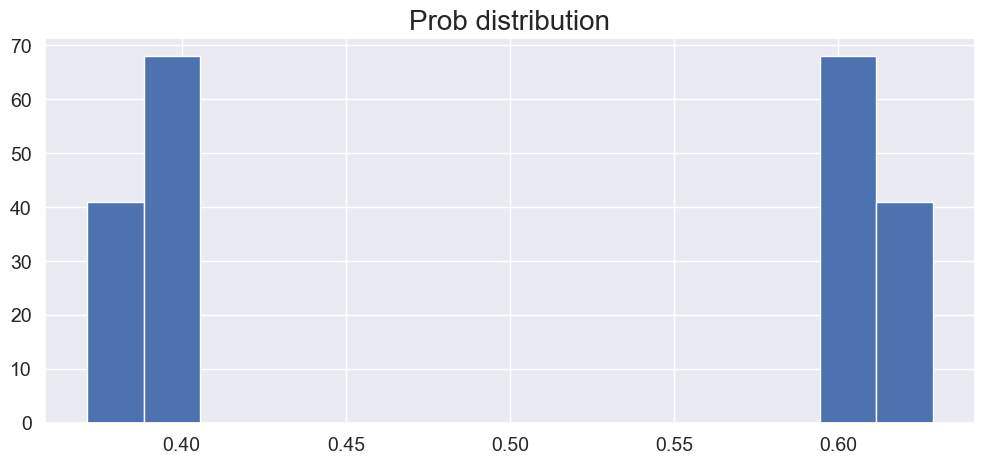

In [99]:
plt.figure(figsize=(12,5))
plt.hist(np.array(y_pred).reshape(len(y_pred)*2), bins=15)
plt.title("Prob distribution")
plt.show()

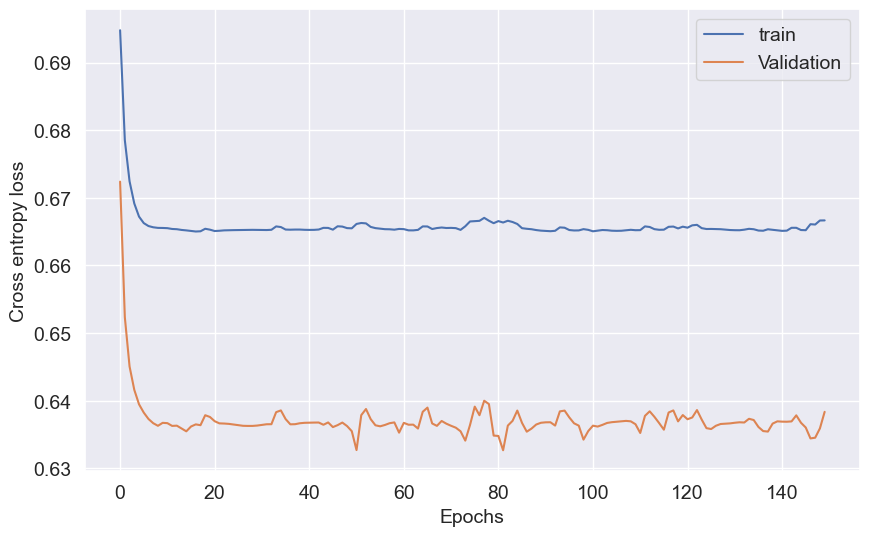

In [100]:
fig,ax = plt.subplots(figsize=(10,6))
ax.plot(metrics['loss_train'], label='train')
ax.plot(metrics['loss_test'], label='Validation')
ax.set_ylabel('Cross entropy loss')
ax.set_xlabel('Epochs')
ax.legend()
#plt.xlim(0,100)
plt.show()

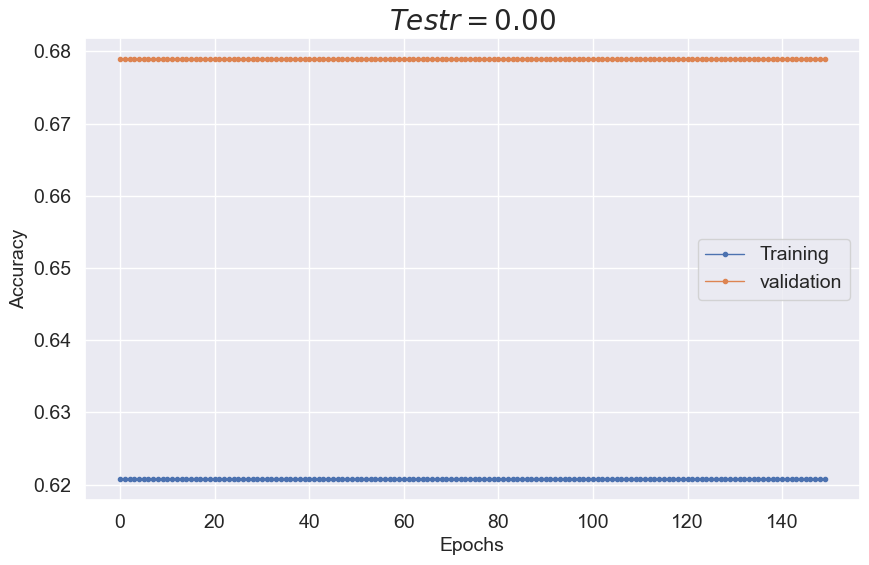

In [101]:
fig,ax = plt.subplots(figsize=(10,6))
ax.plot(metrics['acc_train'], label='Training', linewidth=1,marker='.')
ax.plot(metrics['acc_test'], label='validation', linewidth=1,marker='.')
ax.set_ylabel('Accuracy')
ax.set_xlabel('Epochs')
ax.set_title(r'$Test r = {:.2f}$'.format(np.corrcoef(np.arange(0,len(metrics['acc_test'])), metrics['acc_test'])[0][1]))
ax.legend()
plt.show()

## Kfold Cross validation

In [ ]:
inputs = X
targets = y

eval_scores = {"loss_train" : [], "loss_test" : [], "acc_test" : [], "acc_train" : []}

scores = np.zeros((6,10))
# Define the K-fold Cross Validator
kfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

# K-fold Cross Validation model evaluation
fold_no = 1
for train, test in kfold.split(inputs, targets):
    
    # creating the graphs
    train_data, val_data = create_graph(X.iloc[train], X.iloc[test],
                                         y.iloc[train], y.iloc[test])
    
    # creating the batchs inside the torch DataLoader
    train_loader, val_loader = create_batch(train_data, val_data, batch_size=2)
    

    # Generate a print
    print('------------------------------------------------------------------------')
    print(f'Training for fold {fold_no} ...')

    
    # Train the NN Archithecture
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model = GCN(190, 2, 3).to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-3)
    scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[6,10,18], gamma=0.1, verbose=True)

    
    model.apply(init_weights)

    for layer in model.children():
        if hasattr(layer, 'reset_parameters'):
            layer.reset_parameters()

    min_v_loss = np.inf  

    NUM_EPOCHS = 9
    for epoch in range(1,NUM_EPOCHS + 1):
        loop = tqdm(train_loader)
        train_acc, train_loss = GCN_train(train_loader,loop)
        test_rec, test_prec, test_acc, test_loss, roc_auc, test_f1  = GCN_test(val_loader)
    

        eval_scores['loss_train'].append(train_loss)
        eval_scores['loss_test'].append(test_loss)
        eval_scores['acc_test'].append(test_acc)
        eval_scores['acc_train'].append(train_acc)

    
    scores[0][fold_no - 1] = test_acc
    scores[1][fold_no - 1] = test_rec
    scores[2][fold_no - 1] = test_prec
    scores[3][fold_no - 1] = test_loss
    scores[4][fold_no - 1] = roc_auc
    scores[5][fold_no - 1] = test_f1

    print(f'Score for fold {fold_no}: loss of {test_loss}; acc of {test_acc}%; AUC of {roc_auc}%')

    # Increase fold number
    fold_no = fold_no + 1

------------------------------------------------------------------------
Training for fold 1 ...
Adjusting learning rate of group 0 to 1.0000e-03.


Epoch [9/9]: 100%|████████████████| 327/327 [00:22<00:00, 14.36it/s, loss=0.547]


Score for fold 1: loss of 0.679284356942732; acc of 0.6164383561643836%; AUC of 0.5809178743961352%
------------------------------------------------------------------------
Training for fold 2 ...
Adjusting learning rate of group 0 to 1.0000e-03.


Epoch [9/9]: 100%|█████████████████| 327/327 [00:22<00:00, 14.35it/s, loss=0.56]


Score for fold 2: loss of 0.7109790094298859; acc of 0.6986301369863014%; AUC of 0.6384863123993558%
------------------------------------------------------------------------
Training for fold 3 ...
Adjusting learning rate of group 0 to 1.0000e-03.


Epoch [9/9]: 100%|████████████████| 327/327 [00:19<00:00, 17.13it/s, loss=0.662]


Score for fold 3: loss of 0.6597580901563984; acc of 0.6301369863013698%; AUC of 0.5%
------------------------------------------------------------------------
Training for fold 4 ...
Adjusting learning rate of group 0 to 1.0000e-03.


Epoch [9/9]: 100%|█████████████████| 327/327 [00:19<00:00, 16.87it/s, loss=0.58]


Score for fold 4: loss of 0.6221712911373949; acc of 0.684931506849315%; AUC of 0.5893719806763286%
------------------------------------------------------------------------
Training for fold 5 ...
Adjusting learning rate of group 0 to 1.0000e-03.


Epoch [4/9]: 100%|█████████████████| 327/327 [00:18<00:00, 17.26it/s, loss=0.67]


In [271]:
print('Average Accuracy in CV: {:.2f}({:.2f}) \n'.format(scores[0].mean(), scores[0].std()))
print('Average Recall in CV: {:.2f}({:.2f}) \n'.format(scores[1].mean(), scores[1].std()))
print('Average Precision in CV: {:.2f}({:.2f}) \n'.format(scores[2].mean(), scores[2].std()))
print('Average Loss in test CV: {:.2f}({:.2f}) \n'.format(scores[3].mean(), scores[3].std()))
print('Average AUC in test CV: {:.2f}({:.2f}) \n'.format(scores[4].mean(), scores[4].std()))
print('Average F1 in test CV: {:.2f}({:.2f}) \n'.format(scores[4].mean(), scores[4].std()))

Average Accuracy in CV: 0.66(0.07) 

Average Recall in CV: 0.73(0.04) 

Average Precision in CV: 0.73(0.16) 

Average Loss in test CV: 1.23(0.40) 

Average AUC in test CV: 0.63(0.05) 

Average F1 in test CV: 0.63(0.05) 



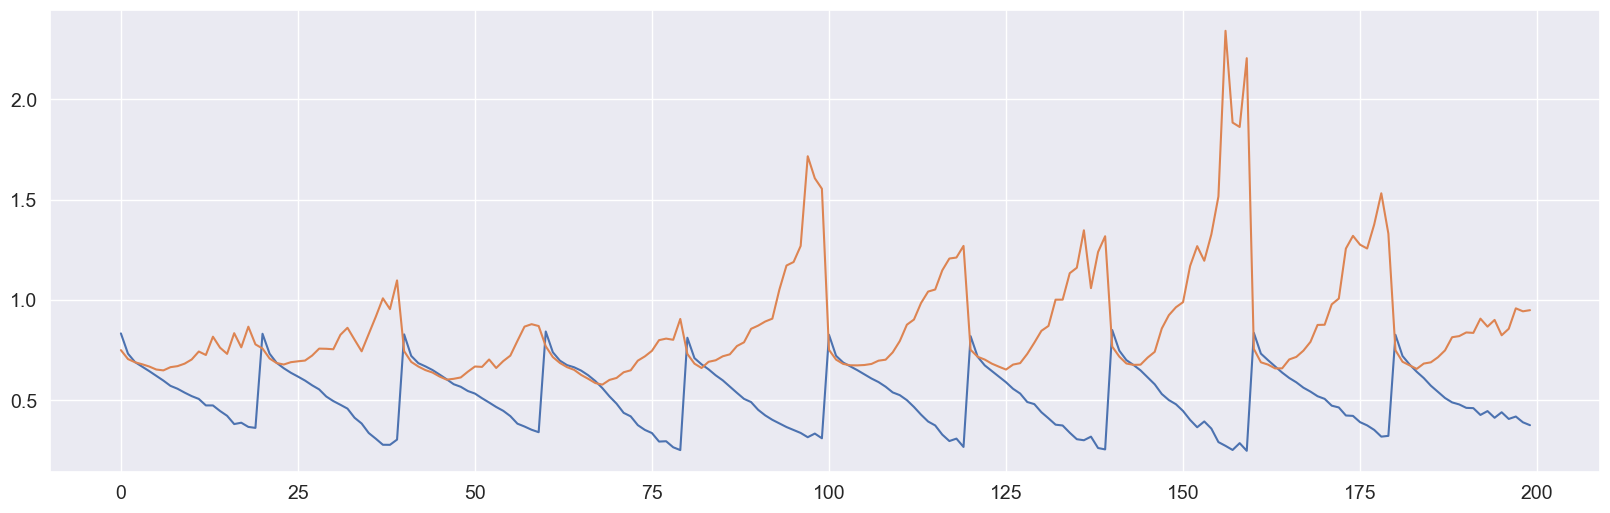

In [272]:
plt.figure(figsize=(20,6))
plt.plot(eval_scores['loss_train'])
plt.plot(eval_scores['loss_test'])

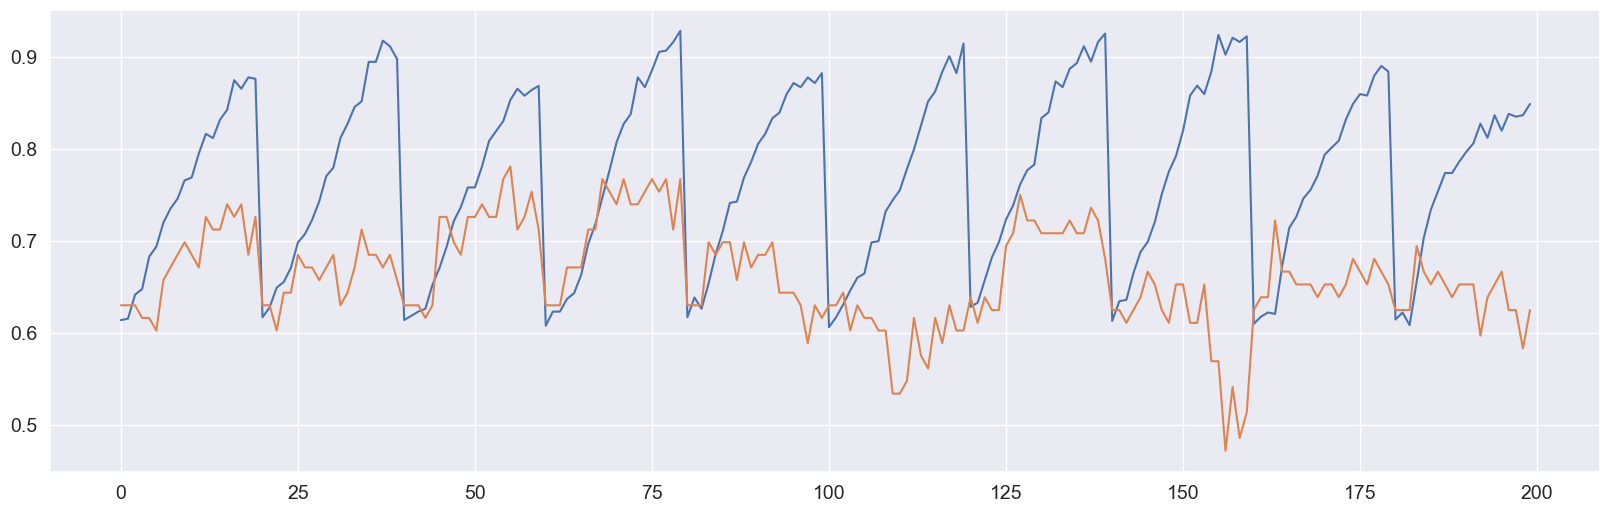

In [273]:
plt.figure(figsize=(20,6))
plt.plot(eval_scores['acc_train'])
plt.plot(eval_scores['acc_test'])

In [27]:
pd.DataFrame(scores.T, columns=['test_acc', 'test_rec_macro',
                                'test_prec_macro', 'test_loss',
                                'test_f1', 'test_roc_auc']).to_csv('/Users/rodrigo/Post-Grad/CC400/Results/GAT.csv')